In [102]:
# Vedh Jaishankar
# Case Study 4

In [ ]:
# Requires: pandas, pandas_datareader, matplotlib, statsmodels
# pip install pandas pandas_datareader matplotlib statsmodels

import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from datetime import datetime
import numpy as np

start = '2018-01-01'
end = datetime.today().strftime('%Y-%m-%d')  # or '2025-06-30'

# ---- series list (monthly)
series_ids = {
    'fedfunds': 'FEDFUNDS',           # effective federal funds rate
    'gs1': 'GS1',                     # 1-year treasury rate
    'gs2': 'GS2',                     # 2-year treasury rate
    'gs5': 'GS5',                     # 5-year treasury rate
    
    # AUTO FINANCING
    'total_vehicle_sales': 'TOTALSA', # total vehicle sales (monthly)
    'retail_auto_sales': 'DAUTOSAAR', # retail sales: motor vehicle & parts dealers
    'ip_motor_parts': 'IPG3361T3S',    # industrial production: motor vehicle parts

    # BANK LENDING
    'c_i_loans': 'TOTCI',             # commercial & industrial loans
    'consumer_loans': 'CCLACBW027SBOG', # consumer loans, all commercial banks

    # CONTROLS
    'unemployment_rate': 'UNRATE',  # unemployment rate
    'cpi_all': 'CPIAUCSL',          # consumer price index 

    # add more series as desired...
}

# Pull data
dfs = {}
for name, sid in series_ids.items():
    print('Downloading', sid)
    df = pdr.DataReader(sid, 'fred', start, end)
    df.name = name
    dfs[name] = df

# Combine into one DataFrame (align on index)
data = pd.concat(dfs.values(), axis=1)
data.columns = list(dfs.keys())

# Some series are rates (fedfunds) and others are levels; for plotting normalize level series to 2019-12=100
# Resample to month-end to align dates
data = data.resample('M').last()
base_date = pd.to_datetime('2019-12-31')
norm = pd.DataFrame(index=data.index)
base_info = {}
for col in data.columns:
    if col == 'fedfunds':
        continue
    s = data[col].astype('float').copy()
    # find last non-null on or before base_date
    cand = s.loc[:base_date].dropna()
    base = None
    if not cand.empty:
        base = cand.iloc[-1]
    else:
        # try fallback: search back up to 12 months
        for k in range(1,13):
            d = base_date - pd.DateOffset(months=k)
            if d in s.index and pd.notnull(s.loc[d]):
                base = s.loc[d]
                base_info[col] = d
                break
    if base is None or base == 0 or pd.isna(base):
        print(f'Skipping {col}: no usable base around {base_date}')
        continue
    norm[col] = s / base * 100
    base_info[col] = base_info.get(col, base_date)

print('Normalization bases used (col: base_date):')
for k,v in base_info.items(): print(k, v)

Normalization bases used (col: base_date):
gs1 2019-12-31 00:00:00
gs2 2019-12-31 00:00:00
gs5 2019-12-31 00:00:00
total_vehicle_sales 2019-12-31 00:00:00
retail_auto_sales 2019-12-31 00:00:00
ip_motor_parts 2019-12-31 00:00:00
c_i_loans 2019-12-31 00:00:00
consumer_loans 2019-12-31 00:00:00
unemployment_rate 2019-12-31 00:00:00
cpi_all 2019-12-31 00:00:00


/var/folders/pw/h37455yn0lbc4w7mq4v36ssc0000gn/T/ipykernel_3313/3303380596.py:51: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').last()


In [104]:
norm.head()

,gs1,gs2,gs5,total_vehicle_sales,retail_auto_sales,ip_motor_parts,c_i_loans,consumer_loans,unemployment_rate,cpi_all
DATE,,,,,,,,,,
2018-01-31,116.129032,126.086957,141.666667,98.199074,115.603645,100.304338,89.526751,90.761471,111.111111,96.222016
2018-02-28,126.451613,135.403727,154.761905,99.748442,118.735763,103.008358,89.826729,90.772855,113.888889,96.481073
2018-03-31,132.903226,141.614907,156.547619,100.977646,116.998861,105.282260,90.305529,91.066514,111.111111,96.499633
2018-04-30,138.709677,147.826087,160.714286,100.531702,114.322323,105.086339,92.279328,92.761974,111.111111,96.750957
2018-05-31,146.451613,155.900621,167.857143,101.932422,118.650342,97.160730,92.517127,93.670262,105.555556,96.969416


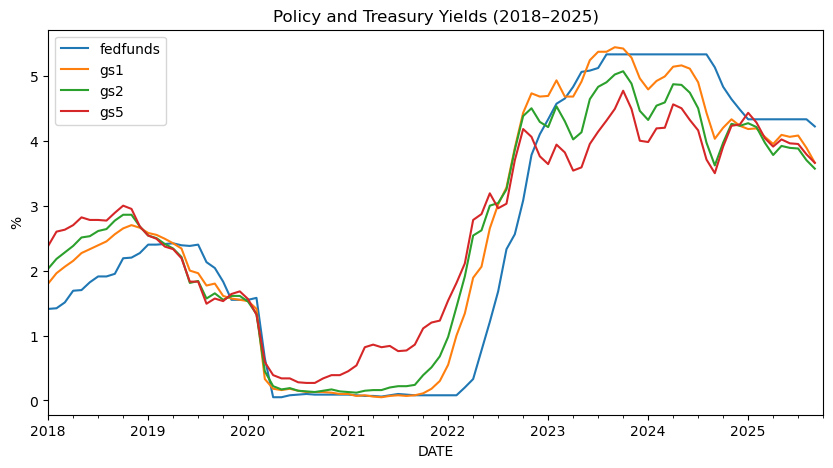

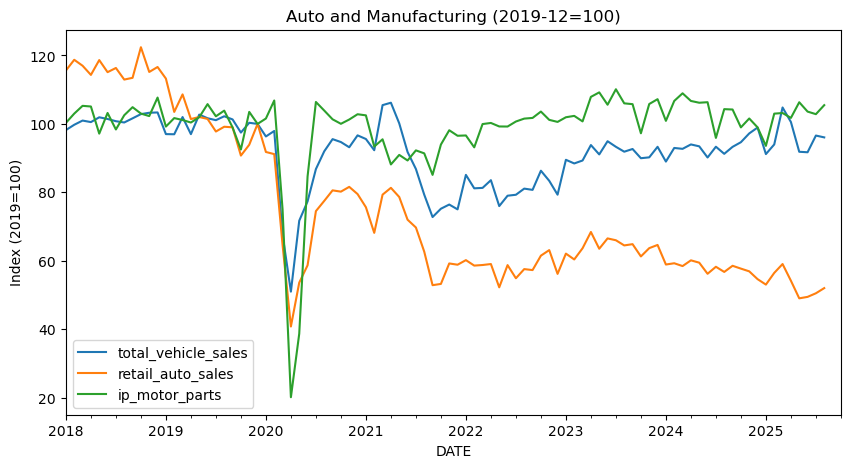

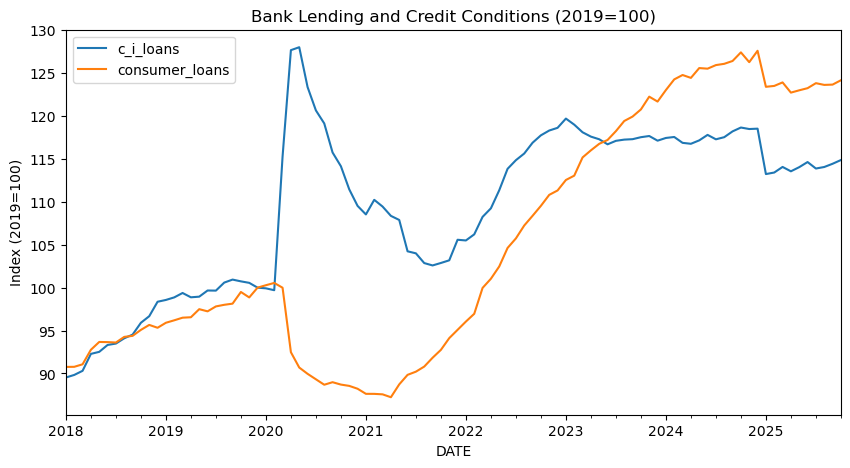

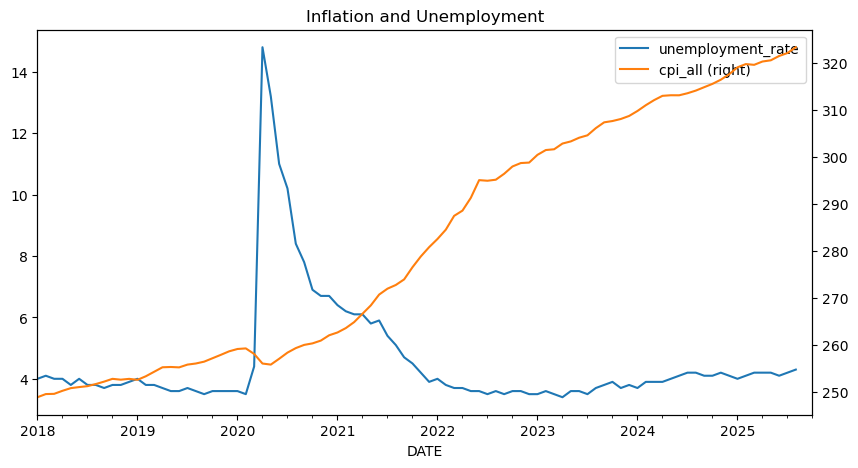

In [111]:
# 1️⃣ Plot policy rates and Treasury yields
data[['fedfunds','gs1','gs2','gs5']].plot(figsize=(10,5), title='Policy and Treasury Yields (2018–2025)')
plt.ylabel('%')
plt.savefig('yields')
plt.show()

# 2️⃣ Plot normalized real economy variables
norm[['total_vehicle_sales','retail_auto_sales','ip_motor_parts']].plot(figsize=(10,5), title='Auto and Manufacturing (2019-12=100)')
plt.ylabel('Index (2019=100)')
plt.savefig('reals')
plt.show()

# 3️⃣ Credit and delinquencies
norm[['c_i_loans','consumer_loans']].plot(figsize=(10,5), title='Bank Lending and Credit Conditions (2019=100)')
plt.ylabel('Index (2019=100)')
plt.savefig('credit')
plt.show()

# 4️⃣ Controls (macro backdrop)
data[['unemployment_rate','cpi_all']].plot(figsize=(10,5), secondary_y='cpi_all', title='Inflation and Unemployment')
plt.savefig('controls')
plt.show()

In [106]:
import numpy as np
import statsmodels.api as sm

# Drop missing rows first (ensures all variables align)
df = data[['total_vehicle_sales','fedfunds','cpi_all','unemployment_rate']].dropna()

# Log-transform and create lags
df['log_sales'] = np.log(df['total_vehicle_sales'])
df['fedfunds_lag1'] = df['fedfunds'].shift(1)
df['fedfunds_lag2'] = df['fedfunds'].shift(2)

# Drop any rows with missing values (due to shift or missing CPI etc.)
df = df.dropna()

# Define X and y
X = sm.add_constant(df[['fedfunds_lag1','fedfunds_lag2','cpi_all','unemployment_rate']])
y = df['log_sales']

# Fit OLS
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     12.95
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           2.80e-08
Time:                        19:34:08   Log-Likelihood:                 87.206
No. Observations:                  90   AIC:                            -164.4
Df Residuals:                      85   BIC:                            -151.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.6013      0.15

In [107]:
# quarterly aggregation
q = data.resample('Q').mean()

# log-diffs (growth) for level series
q['g_sales'] = np.log(q['total_vehicle_sales']).diff()
q['g_loans'] = np.log(q['c_i_loans']).diff()
q['g_ip'] = np.log(q['ip_motor_parts']).diff()
# keep fedfunds level or diff depending on stationarity
q['d_ff'] = q['fedfunds'].diff()

var_df = q[['d_ff','g_sales','g_loans','g_ip']].dropna()

from statsmodels.tsa.api import VAR
model = VAR(var_df)
res = model.fit(maxlags=4, ic='aic')   # selects lag by AIC
print(res.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 20, Oct, 2025
Time:                     19:34:08
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -19.2069
Nobs:                     26.0000    HQIC:                  -21.5498
Log likelihood:           212.896    FPE:                4.72864e-10
AIC:                     -22.4973    Det(Omega_mle):     6.32057e-11
--------------------------------------------------------------------
Results for equation d_ff
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.041564         0.106163            0.392           0.695
L1.d_ff            1.229440         0.436040            2.820           0.005
L1.g_sales         1.549034         2.252493            0.688           0

/var/folders/pw/h37455yn0lbc4w7mq4v36ssc0000gn/T/ipykernel_3313/519207517.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  q = data.resample('Q').mean()


                                SARIMAX Results                                
Dep. Variable:     total_vehicle_sales   No. Observations:                   91
Model:                SARIMAX(1, 0, 1)   Log Likelihood                 113.673
Date:                 Mon, 20 Oct 2025   AIC                           -215.345
Time:                         19:34:09   BIC                           -200.280
Sample:                     02-28-2018   HQIC                          -209.268
                          - 08-31-2025                                         
Covariance Type:                   opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fedfunds              0.0144      0.049      0.296      0.767      -0.081       0.110
cpi_all               0.0091      0.001     12.867      0.000       0.008       0.010
unemployment_rat

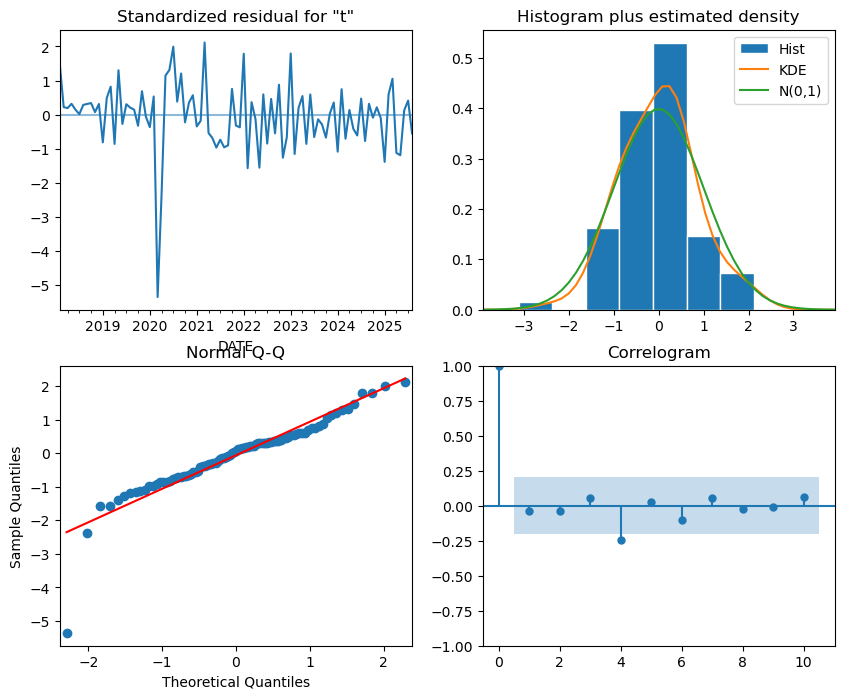

In [108]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y = np.log(data['total_vehicle_sales']).dropna()
exog = data[['fedfunds','cpi_all','unemployment_rate']].shift(1).loc[y.index].dropna()
y = y.loc[exog.index]
model = SARIMAX(y, exog=exog, order=(1,0,1))
res = model.fit(disp=False)
print(res.summary())
res.plot_diagnostics(figsize=(10,8))
plt.show()


In [109]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = sm.add_constant(df[['fedfunds_lag1','fedfunds_lag2','cpi_all','unemployment_rate']])
vifs = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
print(vifs)


const                242.382356
fedfunds_lag1        145.790720
fedfunds_lag2        132.126940
cpi_all                2.315206
unemployment_rate      1.772230
dtype: float64
